In [1]:
import numpy as np
import random as rm
import pandas as pd
from random import seed
from random import random
import matplotlib.pyplot as plt
from pylab import *
from scipy.optimize import curve_fit
from scipy.stats import bernoulli, binom, norm
from scipy import integrate
import time

1. Generating Densities and Related Functions:

The code below generates various densities and related functions for a given mixture of normal distributions.

In [187]:
def f_pi(x, mu, sigma, alpha):
    val = 0
    for i in range(len(mu)):
        val += alpha[i]*norm.pdf(x, mu[i], sigma[i])
    return val

def f_eta_unnormalized(x, mu, sigma, alpha, p):
    return f_pi(x, mu, sigma, alpha)**p

def compute_c(mu, sigma, alpha, p):
    def f_eta_unnormalized_temp(x):
        return f_eta_unnormalized(x, mu, sigma, alpha, p)
    c = integrate.quad(f_eta_unnormalized_temp, -np.inf, np.inf)[0]
    return c

c = compute_c(mu, sigma, alpha, p)
    
def f_eta(x, mu, sigma, alpha, p, c):
    return f_eta_unnormalized(x, mu, sigma, alpha, p)/c

def g(x, mu, sigma, alpha, p, c):
    return(f_pi(x, mu, sigma, alpha)/f_eta(x, mu, sigma, alpha, p, c))

The code below generates various densities and related functions for a fixed mixture of normal distributions. 

We may sometimes use these functions to suppress our (fixed) choice of mixture distribution in the code.

In [244]:
def f_pi_fix(x):
    return(f_pi(x, mu, sigma, alpha))

def f_eta_unnormalized_fix(x):
    return(f_eta_unnormalized(x, mu, sigma, alpha, p))

c = integrate.quad(f_eta_unnormalized_fix, -np.inf, np.inf)[0]

def f_eta_fix(x):
    return f_eta_unnormalized(x, mu, sigma, alpha, p)/c

def g_fix(x):
    return g(x, mu, sigma, alpha, p)

Below we verify that the normalizing constant $c$ for $f_{\eta}$ is being computed correctly.

In [245]:
mu = np.array([10])
sigma = np.array([2])
alpha = np.array([1])
p = 0.5

compute_c(mu, sigma, alpha, p)

3.166466974172319

In [246]:
mu = np.array([-5, 10])
sigma = np.array([2, 7])
alpha = np.array([0.3, 0.7])
p = 0.4

compute_c(mu, sigma, alpha, p)

9.067574489600354

The two examples above are correct, which suggests that $f_{\eta}$ is being computed correctly.

2. Simulating an Auxillary Chain $\{Y_n\}$ using $P$.

The code below simulates a single auxillary chain with transition kernel $P$, whose stationary distribution is $f_{\eta}$.

In [304]:
def p_kernel(y0, prop_sig_y, n, mu, sigma, alpha, p):
        count = 0
        Yn = y0
        estimator = np.array([y0])
        while count < n:
            y = np.random.normal(Yn, prop_sig_y)
            u = np.random.uniform(0,1)
            a = min(f_eta_unnormalized(y, mu, sigma, alpha, p)/f_eta_unnormalized(Yn, mu, sigma, alpha, p), 1)
            if u <= a:
                estimator = np.append(estimator, y)
                Yn = y
                count += 1
        return estimator

Below we verify that the kernel $P$ functions properly, namely that it has stationary distribution $f_{\eta}$. We begin by simulating $\{Y_n\}$.

In [305]:
y0 = 5
prop_sig_y = 1
n = 10000
mu = np.array([0, 3])
sigma = np.array([1, 4])
alpha = np.array([0.3, 0.7])
p = 0.4
y_out = p_kernel(y0, prop_sig_y, n, mu, sigma, alpha, p)

Below we plot a histogram of
$$
m^Y_n \doteq \frac{1}{n+1} \sum\limits_{i=0}^n \delta_{Y_i},
$$
compared to the density $f_{\eta}$, where $\{Y_n\}$ has kernel $P$.

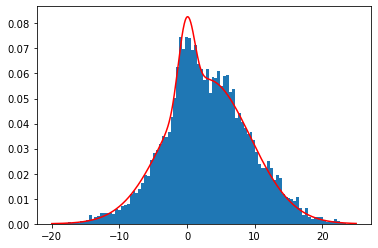

In [306]:
c = compute_c(mu, sigma, alpha, p)
f_eta_plot = lambda y: f_eta(y, mu, sigma, alpha, p, c)

plt.hist(y_out, density = True, bins = 100)

t = np.linspace(-20,25,1000)
vals = f_eta_plot(t)

plt.plot(t,vals, 'r')

3. Simulating a Chain $\{Z_n\}$ with Kernel $K$, whose stationary distribution is $f_{\pi}$.

In [406]:
def k_kernel_nsteps(z0, prop_sig_z, n, mu, sigma, alpha):
        count = 0
        Zn = z0
        estimator = np.array([z0])
        while count < n:
            z = np.random.normal(Zn, prop_sig_z)
            u = np.random.uniform(0,1)
            a = min(f_pi(z, mu, sigma, alpha)/f_pi(Zn, mu, sigma, alpha), 1)
            if u <= a:
                estimator = np.append(estimator, z)
                Zn = z
                count += 1
        return estimator

Below we verify that the kernel $K$ functions properly, namely that it has stationary distribution $f_{\pi}$.

In [459]:
z0 = 5
prop_sig_z = 1
n = 50000
mu = np.array([0, 3])
sigma = np.array([1, 4])
alpha = np.array([0.3, 0.7])
z_out = k_kernel_nsteps(z0, prop_sig_z, n, mu, sigma, alpha)

Below we plot a histogram of
$$
m^Z_n \doteq \frac{1}{n+1} \sum\limits_{i=0}^n \delta_{Z_i},
$$
compared to the density $f_{\pi}$, where $\{Z_n\}$ has kernel $K$.

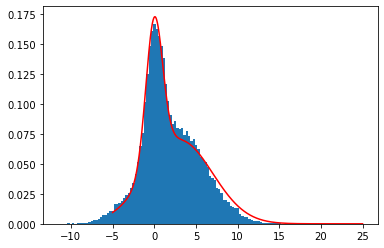

In [460]:
f_pi_plot = lambda z: f_pi(z, mu, sigma, alpha)

plt.hist(z_out, density = True, bins = 100)

t = np.linspace(-5,25,1000)
vals = f_pi_plot(t)

plt.plot(t,vals, 'r')

The function below simulates a single step of a chain with kernel $K$.

In [253]:
def k_kernel(Xn, prop_sig_x, mu, sigma, alpha):
    Xnew = k_kernel_nsteps(Xn, prop_sig_x, 1, mu, sigma, alpha)[-1]
    return(Xnew)

4. Auxillary Functions

Here we introduce several auxillary functions that are used later on.

In [311]:
def sum_g(sum_old, yn, mu, sigma, alpha, p, c):
    return sum_old + g(yn, mu, sigma, alpha, p, c)

def prob_list(y, sum_old, prob_list_old, mu, sigma, alpha, p, c):
        a = sum_old/sum_g(sum_old, y, mu, sigma, alpha, p, c)
        prob_list = prob_list_old*a
        prob_list = np.append(prob_list, g(y, mu, sigma, alpha, p, c)/sum_g(sum_old, y, mu, sigma, alpha, p, c))
        return prob_list

Below we test the *prob_list* function; the results appear to be correct.

In [312]:
c = compute_c(mu, sigma, alpha, p)

sum_old = 10.5
prob_list_old = np.array([0.3,0.7])
prob_list(3, sum_old, prob_list_old, mu, sigma, alpha, p, c)

array([0.26859554, 0.62672292, 0.10468154])

5. Simulating a Single Nonlinear Markov Chain

The function below simulates $n$ time steps of a nonlinear Markov chain $\{X_n\}$ with a single auxillary particle.

In [426]:
#generalized toy example
def simulate(mu, sigma, alpha, p, n, y0, prop_sig_x, prop_sig_y, x0, eps):
    start = time.time()    
    
    c = compute_c(mu, sigma, alpha, p)

    X = np.zeros(n)
    X[0] = x0

    sum_gs = g(y0, mu, sigma, alpha, p, c)
    
    Y = p_kernel(y0, prop_sig_y, n, mu, sigma, alpha, p)
    prob_list_Ys = np.array([1])
        
    for k in range(1, n):
        prob_list_Ys = prob_list(Y[k], sum_gs, prob_list_Ys, mu, sigma, alpha, p, c)
        sum_gs = sum_g(sum_gs, Y[k], mu, sigma, alpha, p, c)
        i = bernoulli(epsilon).rvs(1)
        if i == 0:
            X[k] = k_kernel(x0, prop_sig_x, mu, sigma, alpha)
        else:
            X[k] = np.random.choice(Y[:k+1], p = prob_list_Ys)
        x0 = X[k]    
    
    print("total:"+str(time.time() - start))
    
    return X

The simulation below suggests that our code functions properly.

In [466]:
eps = 0.01
y0 = 0
x0 = 0
n = 30000
prop_sig_x = 2
prop_sig_y = 2

mu = np.array([-5, 5])

x_out = simulate(mu,sigma, alpha, p , n , y0, prop_sig_x, prop_sig_y, x0, eps)

total:62.08102798461914


1. 
First step, sigma = [1,1,1]
mu = [-10, 0, 10]
alpha = [1/3, 1/3, 1/3]


Below we plot the results of this simulation.

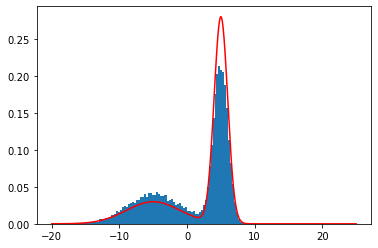

In [467]:
f_pi_plot = lambda z: f_pi(z, mu, sigma, alpha)

plt.hist(x_out, density = True, bins = 100)

t = np.linspace(-20,25,1000)
vals = f_pi_plot(t)

plt.plot(t,vals, 'r')

In [464]:
z0 = 0
prop_sig_z = 2
n = 30000
z_out = k_kernel_nsteps(z0, prop_sig_z, n, mu, sigma, alpha)

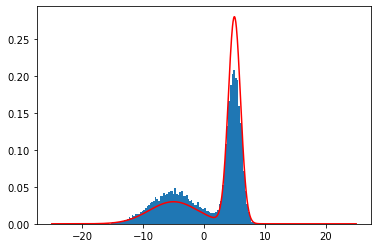

In [465]:
f_pi_plot = lambda z: f_pi(z, mu, sigma, alpha)

plt.hist(z_out, density = True, bins = 100)

t = np.linspace(-25,25,1000)
vals = f_pi_plot(t)

plt.plot(t,vals, 'r')

**OLD CODE BELOW**

In [ ]:
mu = np.array([-10,10])

Choose U ~ {1,...,N}, where N = # of Y particles 

**Generalized Toy Example - Self-Interacting**

In [243]:
# generalized toy example
def simulate(mu, sigma, n, alpha_list, p, y0, prop_sig_x, prop_sig_y x0, epsilon):
    start = time.time()    
    
    def x_sample(x0, epsilon, y0, n, sigma):
        X_list = [0]*n
        X_list[0] = x0
        Y_list = [0]*n
        Y_list[0] = y0
        sum_gs = g(y0)
        Y_list = p_kernel(y0,sigma,n)
        prob_list_Ys = np.array([1])
        
        for k in range(1, n):
            prob_list_Ys = prob_list(Y_list[k], sum_gs, prob_list_Ys)
            sum_gs = sum_g(sum_gs, Y_list[k])
            i = bernoulli(epsilon).rvs(1)
            if i == 0:
                X_list[k] = (k_kernel(x0, sigma))
            else:
                X_list[k] = (np.random.choice(Y_list[:k+1], p = prob_list_Ys))
            x0 = X_list[k]
            
        return X_list
    
    X_list = x_sample(x0, epsilon, y0, n, sigma)
    mean = sum(X_list)/len(X_list)
    
    
    print("total:"+str(time.time() - start))
    
    return [X_list, mean]

SyntaxError: invalid syntax (<ipython-input-243-5f76986aa054>, line 2)

In [14]:
mu_list = [0,17.5,10]
sigma_list = [.5,1,0.7]
alpha_list = [0.4,0.2,0.4]
p = 0.75
n = 10000
y0 = 15
x0 = 10
sigma = 10
epsilon = 0.05

X_list1 = simulate(mu_list, sigma_list, n, alpha_list, p, y0, sigma, x0, epsilon)[0]
'''
X_list2 = simulate(mu_list, sigma_list, n, alpha_list, p, y0, sigma, x0, epsilon)[0]
X_list3 = simulate(mu_list, sigma_list, n, alpha_list, p, y0, sigma, x0, epsilon)[0]
X_list4 = simulate(mu_list, sigma_list, n, alpha_list, p, y0, sigma, x0, epsilon)[0]
X_list5 = simulate(mu_list, sigma_list, n, alpha_list, p, y0, sigma, x0, epsilon)[0]
X_list6 = simulate(mu_list, sigma_list, n, alpha_list, p, y0, sigma, x0, epsilon)[0]
X_list7 = simulate(mu_list, sigma_list, n, alpha_list, p, y0, sigma, x0, epsilon)[0]
X_list8 = simulate(mu_list, sigma_list, n, alpha_list, p, y0, sigma, x0, epsilon)[0]
X_list9 = simulate(mu_list, sigma_list, n, alpha_list, p, y0, sigma, x0, epsilon)[0]
X_list10 = simulate(mu_list, sigma_list, n, alpha_list, p, y0, sigma, x0, epsilon)[0]
'''
mean = simulate(mu_list, sigma_list, n, alpha_list, p, y0, sigma, x0, epsilon)[1]

total:47.3067262172699
total:47.73451590538025


In [15]:
print(mean)

9.15124553356507


In [17]:
def compute_expected_value(mu_list, alpha_list):
    return np.inner(mu_list,alpha_list)

In [18]:
compute_expected_value(mu_list,alpha_list)

7.5

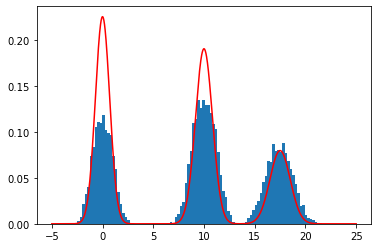

In [19]:
# plot
pdf_pi = lambda x: 0.4*(1/np.sqrt(2*math.pi*0.5))*np.exp((-1/2)*((x-0)**2/0.5)) + 0.2*(1/np.sqrt(2*math.pi*1))*np.exp((-1/2)*((x-17.5)**2/1))+0.4*(1/np.sqrt(2*math.pi*0.7))*np.exp((-1/2)*((x-10)**2/0.7))

plt.hist(X_list1, density = True, bins = 100)
t = np.linspace(-5,25,1000)
vals = pdf_pi(t)
plt.plot(t,vals, 'r')

**Many Particles - Non-Interacting**

In [4]:
# x_i move according to y_i
def simulate_list1(mu_list, sigma_list, n, alpha_list, p, y0_list, sigma, x0_list, epsilon, N):
    start = time.time()
    
    def f_pi(x):
        val = 0
        for i in range(len(mu_list)):
            val += alpha_list[i]*norm.pdf(x,mu_list[i], sigma_list[i]**0.5)
        return val
    

    def pdf_eta(x):
        return f_pi(x)**p

    c = integrate.quad(pdf_eta, -np.inf, np.inf)[0]
    
    def f_eta(x):
        return pdf_eta(x)/c
    
    def g(x):
        return(f_pi(x)/f_eta(x))
    
    '''
    def p_kernel_adjust(y0_list, sigma, n):
        Yn_list = y0_list
        estimator_matrix = np.empty((0,n), int)
        for i in range(len(Yn_list)):
            count = 0
            estimator_list = [y0_list[i]]
            Yn_list = y0_list
            while count<n:
                y = np.random.normal(Yn_list[i], sigma)
                u = np.random.uniform(0,1)
                alpha = (min((pdf_eta(y)/pdf_eta(Yn_list[i])),1))
                if u <= alpha:
                    estimator_list.append(y)
                    Yn_list[i] = y
                    count += 1
            estimator_matrix = np.append(estimator_matrix, [estimator_list[1:]], axis=0)
        return estimator_matrix

    def k_kernel_adjust(x0_list,sigma):
        Xn_list = x0_list
        estimator_matrix = np.empty((0,2), int)
        for i in range(len(Xn_list)):
            count = 0
            estimator_list = [x0_list[i]]
            Xn_list = x0_list
            while count<1:
                y = np.random.normal(Xn_list[i],sigma)
                u = np.random.uniform(0,1)
                alpha = min((pdf_eta(y)/pdf_eta(Xn_list[i])),1)
                if u <= alpha:
                    estimator_list.append(y)
                    Xn_list[i] = y
                    count +=1
            estimator_matrix = np.append(estimator_matrix, [estimator_list], axis=0)
        return estimator_matrix
    '''
    
    def p_kernel(y0, sigma, n):
        count = 0
        Yn = y0
        estimator = [y0]
        while count<n:
            y = np.random.normal(Yn, sigma)
            u = np.random.uniform(0,1)
            alpha = min((pdf_eta(y)/pdf_eta(Yn)),1)
            if u <= alpha:
                estimator.append(y)
                Yn = y
                count += 1
        return estimator
    
    def k_kernel(x0, sigma):
        count = 0
        Xn = x0
        estimator = [x0]
        while count<1:
            y = np.random.normal(Xn,sigma)
            u = np.random.uniform(0,1)
            alpha = min((pdf_eta(y)/pdf_eta(Xn)),1)
            if u <= alpha:
                estimator.append(y)
                Xn = y
                count += 1
        return estimator[-1]
    
    def sum_g(sum_old, yn):
        return sum_old + g(yn)

    def prob_list(y_value, sum_old, prob_list_old):
        a = sum_old/sum_g(sum_old, y_value)
        prob_list = prob_list_old*a
        prob_list = np.append(prob_list, g(y_value)/sum_g(sum_old, y_value))
        return prob_list
    
    def x_sample(x0_list, epsilon, y0_list, n, sigma, N):
        X_matrix = np.empty((0,n),int)
        Y_matrix = np.empty((0,n),int)
        for i in range(N):
            sum_gs = g(y0_list[i])
            X_list = [x0_list[i]]
            Y_list = p_kernel(y0_list[i], sigma, n)
            prob_list_Ys = np.array([1])
            for k in range(1, n):
                prob_list_Ys = prob_list(Y_list[k], sum_gs, prob_list_Ys)
                sum_gs = sum_g(sum_gs, Y_list[k])
                j = bernoulli(epsilon).rvs(1)
                if j == 0:
                    X_list.append(k_kernel(x0_list[i], sigma))
                else:
                    X_list.append(np.random.choice(Y_list[:k+1], p = prob_list_Ys))
            X_matrix = np.append(X_matrix, [X_list], axis=0)
            x0_list[i] = X_matrix[i][-1]
        return X_matrix
    
    X_matrix = x_sample(x0_list, epsilon, y0_list, n, sigma, N)
    mean = X_matrix.sum()/X_matrix.size
    
    print("total:"+str(time.time() - start))
    
    return [mean, X_matrix.flatten()]

In [5]:
mu_list = [0,17.5,10]
sigma_list = [.5,1,0.7]
alpha_list = [0.4,0.2,0.4]
p = 0.75
n = 100
y0_list = [15, -5, 12, 1, -2]
x0_list = [10, 13, -4, -2, 3]
sigma = 10
epsilon = 0.05
N = 1

X_list = simulate_list1(mu_list, sigma_list, n, alpha_list, p, y0_list, sigma, x0_list, epsilon, N)[1]
mean = simulate_list1(mu_list, sigma_list, n, alpha_list, p, y0_list, sigma, x0_list, epsilon, N)[0]


total:0.6765987873077393
total:0.5984041690826416


In [6]:
print(mean)

6.1830916389098


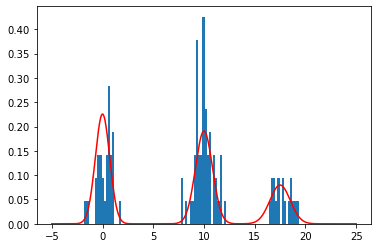

In [7]:
pdf_eta = lambda x: 0.4*(1/np.sqrt(2*math.pi*0.5))*np.exp((-1/2)*((x-0)**2/0.5)) + 0.2*(1/np.sqrt(2*math.pi*1))*np.exp((-1/2)*((x-17.5)**2/1))+0.4*(1/np.sqrt(2*math.pi*0.7))*np.exp((-1/2)*((x-10)**2/0.7))

plt.hist(X_list, density = True, bins = 100)
t = np.linspace(-5,25,1000)
vals = pdf_eta(t)
plt.plot(t,vals, 'r')


**Many Particles - Interacting**

In [8]:
# x_i move according to all ys
def simulate_list2(mu_list, sigma_list, n, alpha_list, p, y0_list, sigma, x0_list, epsilon, N):
    start = time.time()
    
    def f_pi(x):
        val = 0
        for i in range(len(mu_list)):
            val += alpha_list[i]*norm.pdf(x,mu_list[i], sigma_list[i]**0.5)
        return val

    def pdf_eta(x):
        return f_pi(x)**p

    c = integrate.quad(pdf_eta, -np.inf, np.inf)[0]
    
    def f_eta(x):
        return pdf_eta(x)/c
    
    def g(x):
        return(f_pi(x)/f_eta(x))
    
    '''
    def p_kernel_adjust(y0_list, sigma, n):
        Yn_list = y0_list
        estimator_matrix = np.empty((0,n), int)
        for i in range(len(Yn_list)):
            count = 0
            estimator_list = [y0_list[i]]
            Yn_list = y0_list
            while count<n:
                y = np.random.normal(Yn_list[i], sigma)
                u = np.random.uniform(0,1)
                alpha = (min((pdf_eta(y)/pdf_eta(Yn_list[i])),1))
                if u <= alpha:
                    estimator_list.append(y)
                    Yn_list[i] = y
                    count += 1
            estimator_matrix = np.append(estimator_matrix, [estimator_list[1:]], axis=0)
        return estimator_matrix

    def k_kernel_adjust(x0_list,sigma):
        Xn_list = x0_list
        estimator_matrix = np.empty((0,2), int)
        for i in range(len(Xn_list)):
            count = 0
            estimator_list = [x0_list[i]]
            Xn_list = x0_list
            while count<1:
                y = np.random.normal(Xn_list[i],sigma)
                u = np.random.uniform(0,1)
                alpha = min((pdf_eta(y)/pdf_eta(Xn_list[i])),1)
                if u <= alpha:
                    estimator_list.append(y)
                    Xn_list[i] = y
                    count +=1
            estimator_matrix = np.append(estimator_matrix, [estimator_list], axis=0)
        return estimator_matrix
    '''
    
    def p_kernel(y0, sigma, n):
        count = 0
        Yn = y0
        estimator = [y0]
        while count<n:
            y = np.random.normal(Yn, sigma)
            u = np.random.uniform(0,1)
            alpha = min((pdf_eta(y)/pdf_eta(Yn)),1)
            if u <= alpha:
                estimator.append(y)
                Yn = y
                count += 1
        return estimator
    
    def k_kernel(x0, sigma):
        count = 0
        Xn = x0
        estimator = [x0]
        while count<1:
            y = np.random.normal(Xn,sigma)
            u = np.random.uniform(0,1)
            alpha = min((pdf_eta(y)/pdf_eta(Xn)),1)
            if u <= alpha:
                estimator.append(y)
                Xn = y
                count += 1
        return estimator[-1]
    
    def sum_g(sum_old, yn):
        sum_new = sum_old + g(yn)
        return sum_new
    
    def prob_matrix_new(Y_matrix, sum_new):
        prob_matrix = np.zeros((len(Y_matrix),len(Y_matrix[0])))
        for i in range(len(Y_matrix[0])):
            for j in range(len(Y_matrix)):
                prob_matrix[j][i] = g(Y_matrix[j][i])/sum_new
        return prob_matrix
    
    def prob_matrix(Y_list, sum_old, prob_matrix_old):
        g_value = 0
        for i in (Y_list):
            g_value += g(i)
        sum_new = sum_old+g_value
        a = sum_old/sum_new
        prob_matrix = prob_matrix_old*a
        for i in range(len(Y_list)):
            Y_list [i] = g(Y_list[i])/sum_new
        prob_matrix = np.insert(prob_matrix,len(prob_matrix[0])-1,Y_list,axis=1)
        return prob_matrix
    
    def bernoulli_list(epsilon, n):
        b_list = bernoulli(epsilon).rvs(n)
        return b_list
    
    def x_sample(x0_list, epsilon, y0_list, n, sigma, N):
        X_matrix = np.empty(shape=(N,0),dtype='float')
        Y_matrix = np.empty(shape=(N,0),dtype='float')
        Y_matrix = np.insert(Y_matrix,0,y0_list,axis=1)
        X_matrix = np.insert(X_matrix,0,x0_list,axis=1)
        sum_Gs = 0
        Prob_matrix = np.empty(shape=(N,0),dtype='float')
        Prob_list = []
        
        for i in (y0_list):
            sum_Gs += g(i)
            
        for i in y0_list:
            Prob_list.append(g(i)/sum_Gs)
        Prob_matrix = np.insert(Prob_matrix, 0, Prob_list, axis=1)
        
        for i in range(n):
            sum_g = 0
            y_list = []
            x_list = []
            for j in range(N):
                y_list.append(p_kernel(Y_matrix[j][-1], sigma, 1)[-1])
                sum_g += g(y_list[j])
                
            Y_matrix = np.insert(Y_matrix, len(Y_matrix[0])-1, y_list, axis=1)
            Prob_matrix = prob_matrix(Y_matrix[:,i], sum_Gs, Prob_matrix)
            Y_matrix_flatten = Y_matrix.flatten()
            Prob_matrix_flatten = Prob_matrix.flatten()
            sum_Gs += sum_g
            
            for j in range(N):
                b = bernoulli(epsilon).rvs(1)
                if b == 0:
                    x_list.append(k_kernel(X_matrix[j][-1], sigma))
                if b == 1:
                    x_list.append(np.random.choice(Y_matrix_flatten, p = Prob_matrix_flatten))
            
            X_matrix = np.insert(X_matrix, len(X_matrix[0])-1, x_list, axis=1)
            
        return X_matrix
    
    def E_x(X_matrix):
        sum_matrix = X_matrix.sum()
        len_matrix = X_matrix.size
        average_matrix = sum_matrix/len_matrix
        return average_matrix
    
    X_matrix = x_sample(x0_list, epsilon, y0_list, n, sigma, N)
    mean = X_matrix.sum()/X_matrix.size
    
    print("total:"+str(time.time() - start))
    
    return mean, X_matrix.flatten()

In [9]:
mu_list = [0,17.5,10]
sigma_list = [.5,1,0.7]
alpha_list = [0.4,0.2,0.4]
p = 0.75
n = 100
y0_list = [15, 5, 2, 11, 2]
x0_list = [10,3,14,-2,13]
sigma = 10
epsilon = 0.05
N = 5

X_list11 = simulate_list2(mu_list, sigma_list, n, alpha_list, p, y0_list, sigma, x0_list, epsilon, N)[1]
X_list12 = simulate_list2(mu_list, sigma_list, n, alpha_list, p, y0_list, sigma, x0_list, epsilon, N)[1]
X_list13 = simulate_list2(mu_list, sigma_list, n, alpha_list, p, y0_list, sigma, x0_list, epsilon, N)[1]
X_list14 = simulate_list2(mu_list, sigma_list, n, alpha_list, p, y0_list, sigma, x0_list, epsilon, N)[1]
X_list15 = simulate_list2(mu_list, sigma_list, n, alpha_list, p, y0_list, sigma, x0_list, epsilon, N)[1]

# mean = simulate_list2(mu_list, sigma_list, n, alpha_list, p, y0_list, sigma, x0_list, epsilon, N)[0]
# print(mean)

total:1.8377761840820312
total:1.795745849609375
total:1.7590901851654053
total:1.763627052307129
total:1.7202413082122803


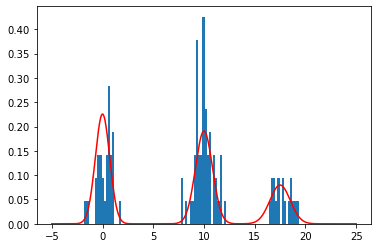

In [10]:
pdf_pi = lambda x: 0.4*(1/np.sqrt(2*math.pi*0.5))*np.exp((-1/2)*((x-0)**2/0.5)) + 0.2*(1/np.sqrt(2*math.pi*1))*np.exp((-1/2)*((x-17.5)**2/1))+0.4*(1/np.sqrt(2*math.pi*0.7))*np.exp((-1/2)*((x-10)**2/0.7))

plt.hist(X_list, density = True, bins = 100)
t = np.linspace(-5,25,1000)
vals = pdf_pi(t)
plt.plot(t,vals, 'r')